## Описание проекта

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.


### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import seaborn as sns
warnings.filterwarnings("ignore")


In [4]:
df=pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
df.to_csv('taxi.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.index.min()

Timestamp('2018-03-01 00:00:00')

In [6]:
df.index.max()

Timestamp('2018-08-31 23:50:00')

В данном датасете 26496 строк 1 столбец. При загрузке датасета мы дату сразу перевели в формат DateTime и поместили его в индекс. Наш датасет представлей за период с 2018-03-01 по 2018-08-31. Целевой признак-num_orders- количество заказов.

In [7]:
# Отсортируем и сгруппируем по часам. В num_orders поместим сумму заказов за час
df.sort_index(inplace=True)
df=df['2018-03':'2018-08'].resample('1H').sum()

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Анализ

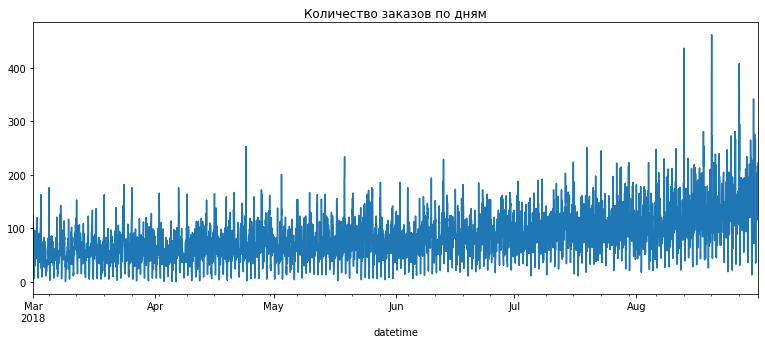

In [9]:
plt.figure(figsize=(13,5))
plt.title('Количество заказов по дням')
df['num_orders'].plot()

Временной ряд не стационарен. Со временем меняется его среднее значение и дисперсия.

In [10]:
# Создадим столбец со скользящим средним и окном 10.
df['rolling_mean']=df['num_orders'].rolling(window=10).mean()
#df['rolling_std']=df['num_orders'].rolling(window=10).std()
df=df.fillna(0)
#df['rolling_std']=df.rolling(window=4).mean()

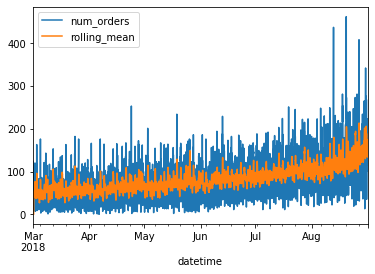

In [11]:
df.plot()

In [12]:
# Произвожу декомпозицию временного ряда, что увидеть тренд, сезонность и белый шум
decomposed = seasonal_decompose(df['num_orders'])


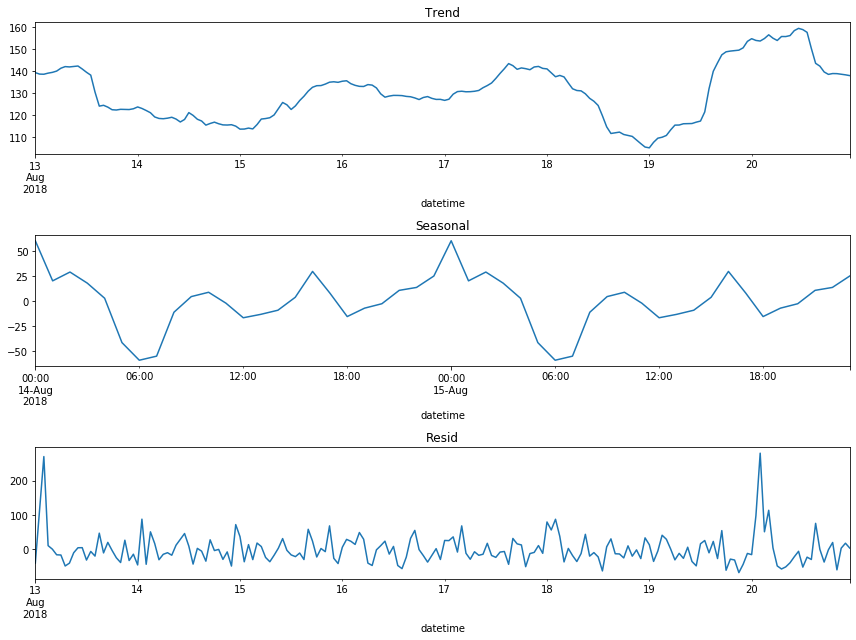

In [13]:
plt.figure(figsize=(12, 9))
plt.subplot(311)

decomposed.trend['2018-08-13':'2018-08-20'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)

decomposed.seasonal['2018-08-14':'2018-08-15'].plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)

decomposed.resid['2018-08-13':'2018-08-20'].plot(ax=plt.gca())
plt.title('Resid')
plt.tight_layout()

В тренде я виделил участок в неделю. Если взять больше, то можно уже наблюдать сезонность. Можно наблюдать, как меняется количество заказов в течении недели.
Быляй шум как и положенно с средним отклонением в райне 0. 
По сезонности можно увидеть как меняется количество заказов в течении дня и наблюдать повторяемость этого на следующие дни.

### Да, согласен! Графики сверху подправил!

In [14]:
# Для дальнейшего прогнозирования временного ряда, нам понадобится преобразовать его стационарный
df=df-df.shift(fill_value=0)

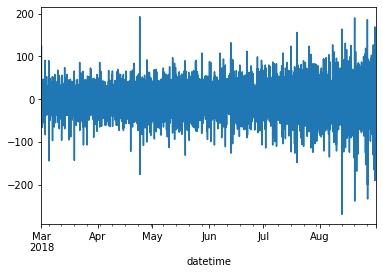

In [15]:
df['num_orders'].plot()

Ряд стал более стационарен. Среднее значение в целом одинаковое, но дисперсия немного скачет. Но стало лучше. Такой ряд можно прогнозировать.

# 3. Обучение

In [16]:
# Готовлю функция для создания календарных признаков и отстающих значений
def make_features(df, max_lag, rolling_mean_size):
  
    df['Year']=df.index.year
    df['Month']=df.index.month
    df['Day']=df.index.day
    df['Day_of_week']=df.index.dayofweek
    
    for i in range(1,max_lag+1):
        df['lag_{}'.format(i)]=df['num_orders'].shift(i)
    df['rolling_mean']=df['num_orders'].shift().rolling(window=rolling_mean_size).mean()
    return df
    


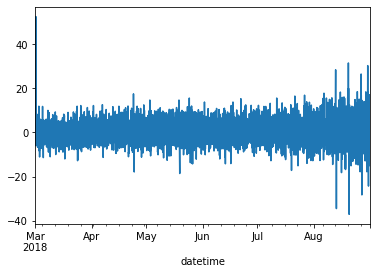

In [17]:
df['rolling_mean'].plot()

### model LinearRegression

In [18]:
df_line=df.copy()

In [19]:
#30б5
df_line=make_features(df_line,23,22)

In [20]:
df_line=df_line.dropna()
target=df_line['num_orders']
features=df_line.drop(['num_orders'],axis=1)

train_valid_features,test_features,train_valid_target,test_target=train_test_split(features,target,test_size=0.1,shuffle=False)
#train_features,valid_features,train_target,valid_target=train_test_split(train__valid_features,train_valid_target,test_size=0.3,shuffle=False)

In [21]:
# Предсказание на тестовой
model_line=LinearRegression().fit(train_valid_features,train_valid_target)
predict_line=model_line.predict(test_features)
RMSE_line=np.sqrt(mean_squared_error(predict_line,test_target))
print(RMSE_line)

44.94012636708619


In [22]:
# Готовлю функцию которая предсказывает
#def predict(train_features,train_target,valid_features):
#    model=LinearRegression().fit(train_features,train_target)
#    predict=model.predict(valid_features)
 #   return np.sqrt(mean_squared_error(predict,valid_target))

In [23]:
#df_line=df

In [24]:
# В цикле подберем лучшие значения lag и скользящего среднего.
#%%time

#lag=30
#rolling_mean=30
#min_lag=[]
#min_rolling_mean=[]
#df_predict=[]
#for i in range(1,lag):
#    for j in range(1,rolling_mean):
       
#        df_predict.append(split_predict(make_features(df_line,i,j)))
#        min_lag.append(i)
#        min_rolling_mean.append(j)

#dict_rmse={'lag':min_lag,'rolling_mean':min_rolling_mean,'RMSE':df_predict}
#df_rmse=pd.DataFrame(dict_rmse)




In [25]:
#df_rmse.loc[df_rmse['RMSE']==df_rmse['RMSE'].min()]

In [26]:
#rezult_line=df_rmse['RMSE'].min()
#rezult_line

Лучшее значение при lag=23 и rolling_mean=26	RMSE=44.577084

### model RandomForestRegressor

Подберем лучшие значениея max_depth и n_estimators c фиксированными значениями lag=4 и	rolling_mean=23

In [27]:
df_random_forest=df.copy()

In [28]:
# Примем для начального значения lag=4 и rolling_mean=23 (лучшие значения из Линейной регрессии)
df_random_forest=make_features(df_random_forest,23,22)

In [29]:
#Готовлю признаки и целевой признак
df_random_forest=df_random_forest.dropna()
target=df_random_forest['num_orders']
features=df_random_forest.drop(['num_orders'],axis=1)
train_features,valid_features,train_target,valid_target=train_test_split(features,target,test_size=0.1,shuffle=False)

In [30]:
# Подбираяю лучший гиперпараметр max_depth
for max_depth in range(1,20):
    model=RandomForestRegressor(n_estimators=5,max_depth=max_depth,random_state=1234).fit(train_features,train_target)
    predict=model.predict(valid_features)
    print('max_depth:{}'.format(max_depth),'RMSE:{}'.format(np.sqrt(mean_squared_error(predict,valid_target))))

max_depth:1 RMSE:53.40443999391223
max_depth:2 RMSE:49.640146712429576
max_depth:3 RMSE:46.933440393006315
max_depth:4 RMSE:46.383938490091765
max_depth:5 RMSE:46.343060170572244
max_depth:6 RMSE:46.38398531754227
max_depth:7 RMSE:47.133095625939156
max_depth:8 RMSE:47.08951512947853
max_depth:9 RMSE:46.675711863193015
max_depth:10 RMSE:46.77838021103736
max_depth:11 RMSE:46.93507206639709
max_depth:12 RMSE:46.908623748808026
max_depth:13 RMSE:48.22445611014974
max_depth:14 RMSE:46.66488774055988
max_depth:15 RMSE:48.29735987955283
max_depth:16 RMSE:46.747946732553
max_depth:17 RMSE:47.578341064892236
max_depth:18 RMSE:47.823111331222556
max_depth:19 RMSE:47.75199278724585


Best max_depth:5 RMSE:46.343060170572244

In [31]:
# Подбираяю лучший гиперпараметр n_estimators
for n_estim in range(1,100):
    model=RandomForestRegressor(n_estimators=n_estim,max_depth=5,random_state=1234).fit(train_features,train_target)
    predict=model.predict(valid_features)
    print('n_estimator:{}'.format(n_estim),'RMSE:{}'.format(np.sqrt(mean_squared_error(predict,valid_target))))

n_estimator:1 RMSE:50.79163258174838
n_estimator:2 RMSE:47.3284575042985
n_estimator:3 RMSE:46.89629442472363
n_estimator:4 RMSE:46.79225299080269
n_estimator:5 RMSE:46.343060170572244
n_estimator:6 RMSE:46.02795604518478
n_estimator:7 RMSE:46.04330060743112
n_estimator:8 RMSE:45.93979453540072
n_estimator:9 RMSE:46.13660233668369
n_estimator:10 RMSE:45.7890629785559
n_estimator:11 RMSE:45.73628800234919
n_estimator:12 RMSE:45.904976896273645
n_estimator:13 RMSE:46.027607271722914
n_estimator:14 RMSE:46.058227575532
n_estimator:15 RMSE:45.80705189737239
n_estimator:16 RMSE:45.75180689611719
n_estimator:17 RMSE:45.860238295307134
n_estimator:18 RMSE:45.83352569594848
n_estimator:19 RMSE:45.75221214125467
n_estimator:20 RMSE:45.8039305261677
n_estimator:21 RMSE:45.731610214454065
n_estimator:22 RMSE:45.68035461946472
n_estimator:23 RMSE:45.64226049766447
n_estimator:24 RMSE:45.59748172497275
n_estimator:25 RMSE:45.55514299147703
n_estimator:26 RMSE:45.59243062006979
n_estimator:27 RMSE:4

Best n_estimator:33 RMSE:45.441865465215294

Найдем лучшее значение lan и rolling_mean при лучших значениях max_depht=6 и n_estimators=22

Лучшее значение lag=1	rolling_mean=22	RMSE=45.681861

### CatBoostRegressor

In [40]:
df_cat=df.copy()

In [41]:
# # Примем для начального значения lag=4 и rolling_mean=23 (лучшие значения из Линейной регрессии)
df_cat=make_features(df_cat,22,22)

In [42]:
# Готовлю целевой признак и признаки
df_cat=df_cat.dropna()
target=df_cat['num_orders']
features=df_cat.drop(['num_orders'],axis=1)
train_features,test_features,train_target,test_target=train_test_split(features,target,test_size=0.1,shuffle=False)

In [43]:
# Ставлю значения гиперпараметров depth=10, iterations=2000 и  learning_rate=0.1
#%%time

#plt.style.use('ggplot') 
#for i in range(50,500,50):
model_cat=CatBoostRegressor(depth=10,
                        iterations=700,
                        learning_rate=0.1,
                        loss_function='RMSE').fit(train_features,train_target,verbose=100)

predict=model_cat.predict(test_features)
rmse=mean_squared_error(predict,test_target)
print('RMSE: ',np.sqrt(rmse))
#plt.figure( figsize= (10 , 10 )) 
#sns.regplot(valid_tagret,  predict,  fit_reg= True,  scatter_kws= {"s":  100 }) 


0:	learn: 35.1921391	total: 287ms	remaining: 3m 20s
100:	learn: 15.6931565	total: 17s	remaining: 1m 40s
200:	learn: 8.8905054	total: 33.5s	remaining: 1m 23s
300:	learn: 5.3473250	total: 50.2s	remaining: 1m 6s
400:	learn: 3.2127372	total: 1m 6s	remaining: 49.8s
500:	learn: 1.8779783	total: 1m 23s	remaining: 33.2s
600:	learn: 1.1363527	total: 1m 40s	remaining: 16.5s
699:	learn: 0.7041307	total: 1m 56s	remaining: 0us
RMSE:  43.54102381657518


In [44]:
rezult_cat=np.sqrt(rmse)
rezult_cat

43.54102381657518

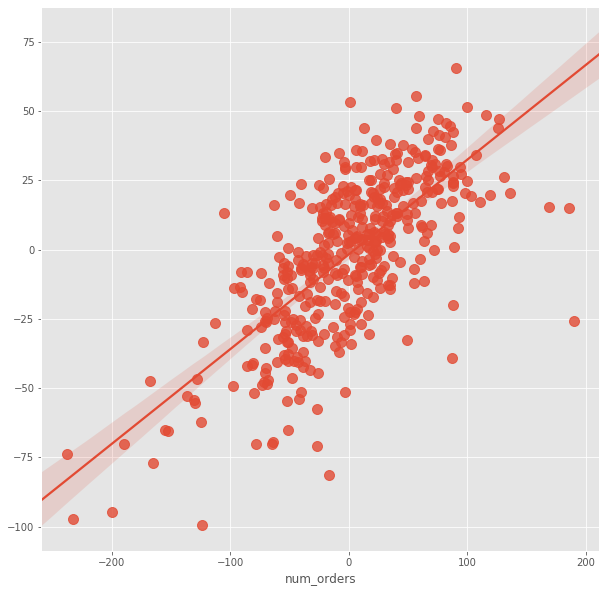

In [45]:
plt.style.use('ggplot') 
plt.figure( figsize= (10 , 10 )) 
sns.regplot(valid_target,  predict,  fit_reg= True,  scatter_kws= {"s":  100 }) 


### Вывод:

In [46]:
np.array([RMSE_line,RMSE_forest,rezult_cat])

array([44.94012637, 45.44186547, 43.54102382])

In [47]:
df_rezult=pd.DataFrame(np.array([RMSE_line,RMSE_forest,rezult_cat]),index=['LinearRegression','RandomForestRegressor','CatBoostRegressor'])
df_rezult.set_axis(['RMSE'],axis='columns',inplace=True)
df_rezult

,RMSE
LinearRegression,44.940126
RandomForestRegressor,45.441865
CatBoostRegressor,43.541024


По всем трем моделям я получил показатель RMSE не больше 48. Можно выделить, что LinearRegression показала себя лучше всех. Я не прогонял циклом lag и скользящее среднее для RandomForest и CatBoostRegressor. Думаю, что если бы это сделал, то результат был бы лучше. Но время расчета для этих моделей очень большое, поэтому я не стал это делать.